In [1]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

# from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import filters

# plotting
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import pickle

In [2]:
xhist_tas = pickle.load(open('../data/saved/xhist_tas.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/saved/xrcp_tas.pkl', 'rb'))

xhist_pr = pickle.load(open('../data/saved/xhist_pr.pkl', 'rb'))
xrcp_pr = pickle.load(open('../data/saved/xrcp_pr.pkl', 'rb'))

In [10]:
from sklearn.decomposition import PCA

In [7]:
nmod = len(xhist_tas)
ntrain_tas = xhist_tas[0].shape[0]
ntest_tas = xrcp_tas[0].shape[0]

ntrain_pr = xhist_pr[0].shape[0]
ntest_pr = xrcp_pr[0].shape[0]

xtrain_tas = []
for m2 in range(nmod):
    xtrain_tas.append(xhist_tas[m2].reshape(ntrain_tas, -1))
xtrain_tas = jnp.hstack(xtrain_tas)

xtest_tas = []
for m2 in range(nmod):
    xtest_tas.append(xrcp_tas[m2].reshape(ntest_tas, -1))
xtest_tas = jnp.hstack(xtest_tas)


xtrain_pr = []
for m2 in range(nmod):
    xtrain_pr.append(xhist_pr[m2].reshape(ntrain_pr, -1))
xtrain_pr = jnp.hstack(xtrain_pr)

xtest_pr = []
for m2 in range(nmod):
    xtest_pr.append(xrcp_pr[m2].reshape(ntest_pr, -1))
xtest_pr = jnp.hstack(xtest_pr)

In [8]:
xtrain_tas = (xtrain_tas - np.mean(xtrain_tas, axis = 1)[:,None]) / np.std(xtrain_tas, axis = 1)[:,None]
xtest_tas = (xtest_tas - np.mean(xtest_tas, axis = 1)[:,None]) / np.std(xtest_tas, axis = 1)[:,None]

xtrain_pr = (xtrain_pr - np.mean(xtrain_pr, axis = 1)[:,None]) / np.std(xtrain_pr, axis = 1)[:,None]
xtest_pr = (xtest_pr - np.mean(xtest_pr, axis = 1)[:,None]) / np.std(xtest_pr, axis = 1)[:,None]

In [11]:
pca_tas = PCA(n_components=2)
pca_tas.fit(xtrain_tas)

pca_pr = PCA(n_components=2)
pca_pr.fit(xtrain_pr)

PCA(n_components=2)

In [13]:
pc_train_tas = pca_tas.transform(xtrain_tas)
pc_test_tas = pca_tas.transform(xtest_tas)

pc_train_pr = pca_pr.transform(xtrain_pr)
pc_test_pr = pca_pr.transform(xtest_pr)

In [15]:
def rescale(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [16]:
pc_train_tas = rescale(pc_train_tas)
pc_test_tas = rescale(pc_test_tas)
pc_train_pr = rescale(pc_train_pr)
pc_test_pr = rescale(pc_test_pr)

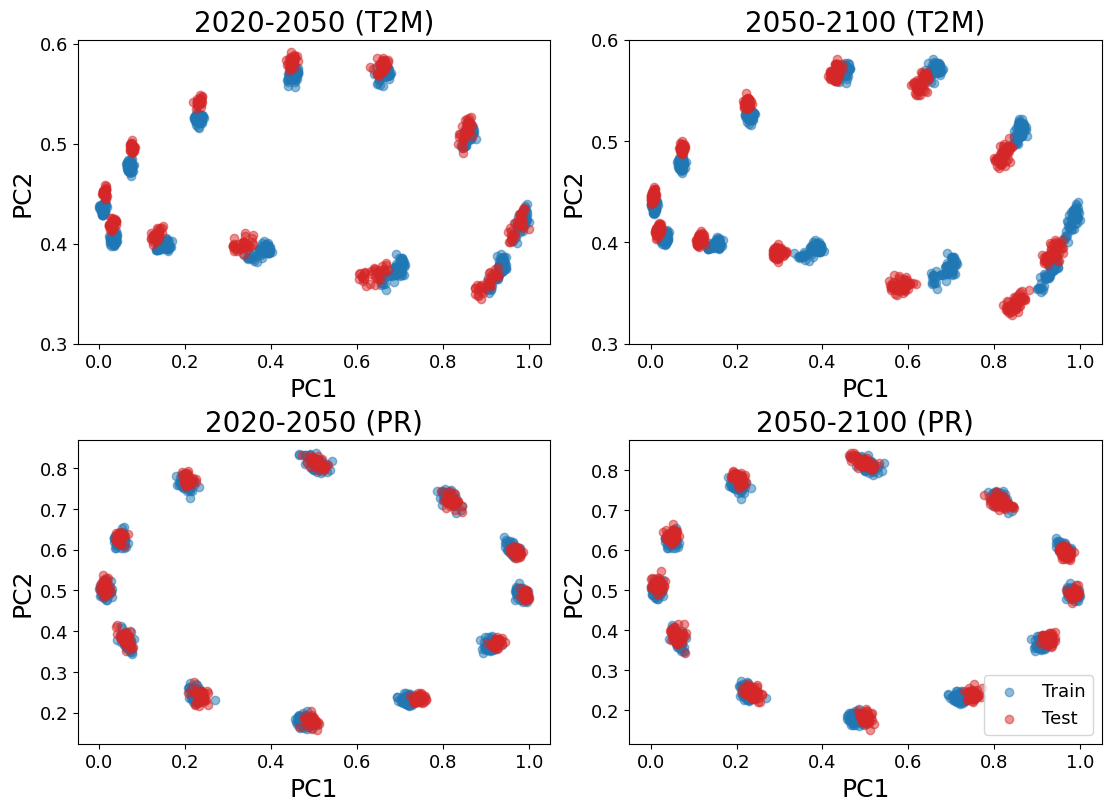

In [23]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors

fig = plt.figure(constrained_layout = True, figsize = (11, 8))
gs = GridSpec(2, 2, width_ratios = [1, 1], figure = fig)

plt.rc('ytick', labelsize = 13)
plt.rc('xtick', labelsize = 13)

ax = plt.subplot(gs[0, 0])
ax.scatter(pc_train_tas[:,0], pc_train_tas[:,1], label = 'Train', c = 'C10', alpha = 0.5)
ax.scatter(pc_test_tas[0:(336+72),0], pc_test_tas[0:(336+72),1], label = 'Test', c = 'C3', alpha = 0.5)
ax.set_xlabel('PC1', fontsize = 18)
ax.set_ylabel('PC2', fontsize = 18)
ax.set_yticks([0.3, 0.4, 0.5, 0.6])
ax.set_title('2020-2050 (T2M)', fontsize = 20)
# ax.legend(fontsize = 13)
# ax.set_aspect('auto', adjustable=None)


# ax.text(0.02, 0.925, 'A', fontsize=32, fontweight='bold', transform=plt.gcf().transFigure)

ax = plt.subplot(gs[0, 1])
ax.scatter(pc_train_tas[:,0], pc_train_tas[:,1], label = 'Train', c = 'C0', alpha = 0.5)
ax.scatter(pc_test_tas[(336+72):,0], pc_test_tas[(336+72):,1], label = 'Test', c = 'C3', alpha = 0.5)
ax.set_xlabel('PC1', fontsize = 18)
ax.set_ylabel('PC2', fontsize = 18)
ax.set_yticks([0.3, 0.4, 0.5, 0.6])
ax.set_title('2050-2100 (T2M)', fontsize = 20)
# ax.legend(fontsize = 13)
# ax.set_aspect('auto', adjustable=None)



ax = plt.subplot(gs[1, 0])
ax.scatter(pc_train_pr[:,0], pc_train_pr[:,1], label = 'Train', c = 'C10', alpha = 0.5)
ax.scatter(pc_test_pr[0:(336+72),0], pc_test_pr[0:(336+72),1], label = 'Test', c = 'C3', alpha = 0.5)
ax.set_xlabel('PC1', fontsize = 18)
ax.set_ylabel('PC2', fontsize = 18)
# ax.set_yticks([0.3, 0.4, 0.5, 0.6])
ax.set_title('2020-2050 (PR)', fontsize = 20)
# ax.legend(fontsize = 13)
# ax.set_aspect('auto', adjustable=None)


# ax.text(0.02, 0.925, 'A', fontsize=32, fontweight='bold', transform=plt.gcf().transFigure)

ax = plt.subplot(gs[1, 1])
ax.scatter(pc_train_pr[:,0], pc_train_pr[:,1], label = 'Train', c = 'C0', alpha = 0.5)
ax.scatter(pc_test_pr[(336+72):,0], pc_test_pr[(336+72):,1], label = 'Test', c = 'C3', alpha = 0.5)
ax.set_xlabel('PC1', fontsize = 18)
ax.set_ylabel('PC2', fontsize = 18)
# ax.set_yticks([0.1, 0.4, 0.5, 0.8])
ax.set_title('2050-2100 (PR)', fontsize = 20)
ax.legend(fontsize = 13)
# ax.set_aspect('auto', adjustable=None)

plt.show()